In [65]:
%pylab inline

import numpy as np
import pandas as pd
import scipy.stats

data = pd.read_csv("gtex_capillary_summary_v2.tsv", sep="\t")

########### Filters + preprocessing ###############
# Filter non-STR loci (AMEL, Yindel)
data = data[data["Marker"].apply(lambda x: x not in ["AMEL", "Yindel"])]
data = data[~np.isnan(data["Depth "])]
data.to_csv("GTEx_WGS_vs_capillary_RAW.csv")

# Convert all gts to floats
for col in ["Allele1 - Cap", "Allele2 - Cap", "Allele1 - WGS", "Allele2 - WGS"]:
    data[col] = data[col].apply(float)

# Filter no call
data = data[~np.isnan(data["Allele1 - WGS"])]
data = data[~(np.isnan(data["Allele1 - Cap"]) & np.isnan(data["Allele2 - Cap"]))]

# Locus offsets
data["Offset"] = 0
data.ix[data["Marker"]=="D19S433", "Offset"] = 2
data.ix[data["Marker"]=="vWA", "Offset"] = 2
for col in ["Allele1 - Cap", "Allele2 - Cap"]:
    data[col] = data[col]+data["Offset"]

########### Compute quality metrics ###############

def GetGenotypeConcordance(x):
    return int((x["Allele1 - Cap"] == x["Allele1 - WGS"] and
        x["Allele2 - Cap"] == x["Allele2 - WGS"]) or \
        (x["Allele1 - Cap"] == x["Allele2 - WGS"] and
        x["Allele2 - Cap"] == x["Allele1 - WGS"]))
 
def GetGenotypeConcordanceDIFF(x):
    diff1 = abs(int(x["Allele1 - Cap"]) - int(x["Allele2 - Cap"]))
    diff2 = abs(int(x["Allele1 - WGS"]) - int(x["Allele2 - WGS"]))
    return diff1 == diff2

def GetGenotypeConcordanceINT(x):
    return int((int(x["Allele1 - Cap"]) == int(x["Allele1 - WGS"]) and
        int(x["Allele2 - Cap"]) == int(x["Allele2 - WGS"])) or \
        (int(x["Allele1 - Cap"]) == int(x["Allele2 - WGS"]) and
        int(x["Allele2 - Cap"]) == int(x["Allele1 - WGS"])))

data["gtconcordance"] = data.apply(GetGenotypeConcordance, 1)
data["gtconcordance_int"] = data.apply(GetGenotypeConcordanceINT, 1)
data["gtconcordance_diff"] = data.apply(GetGenotypeConcordanceDIFF, 1)

########### Summarize concordance by sample ###############
persample = data.groupby("Sample ID", as_index=False).agg({"gtconcordance": np.mean, "Marker": len})
persample = persample.sort_values("gtconcordance", ascending=False)
persample.to_csv("GTEx_WGS_vs_capillary_persample.csv")

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


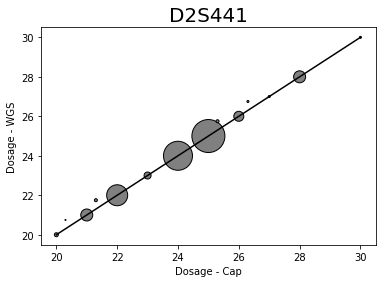

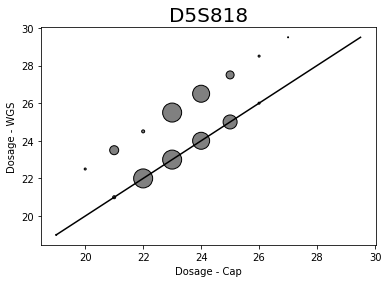

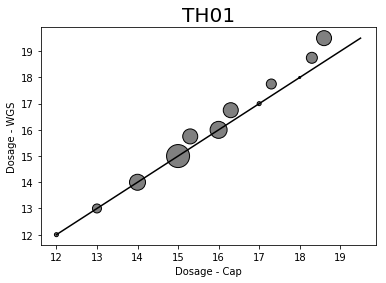

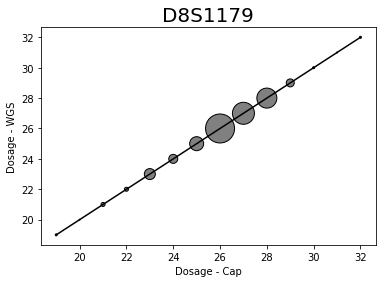

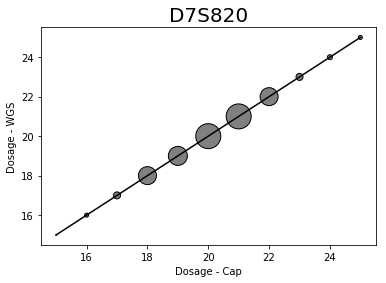

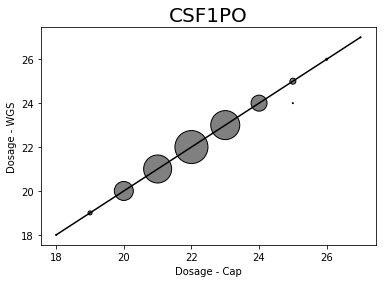

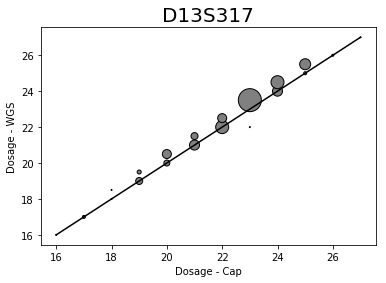

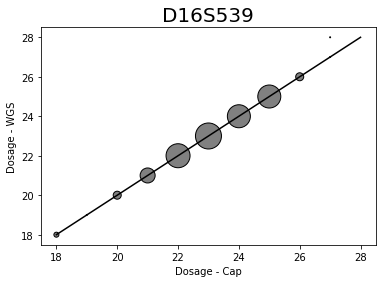

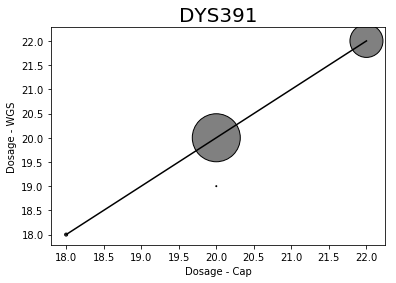

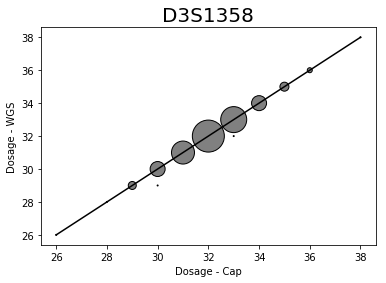

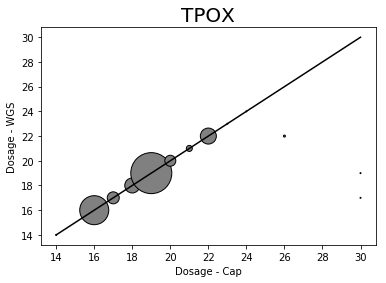

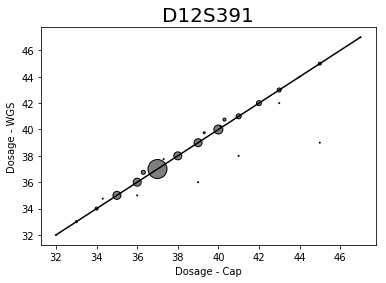

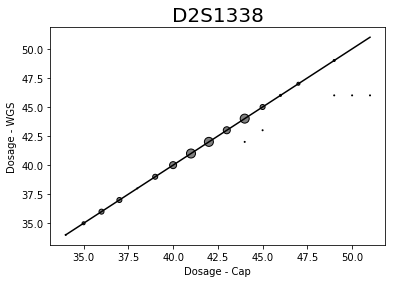

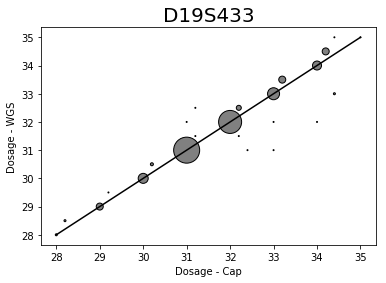

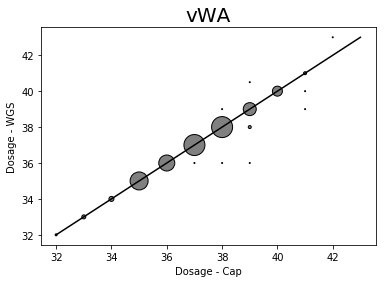

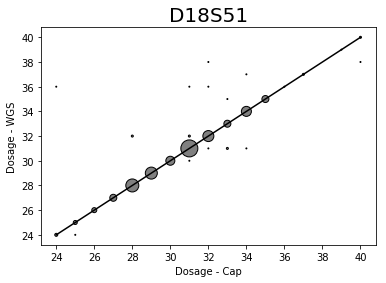

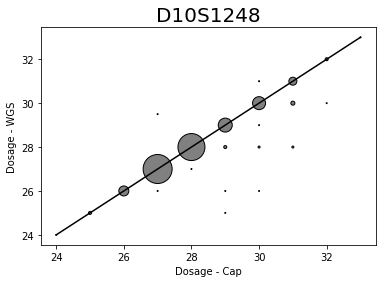

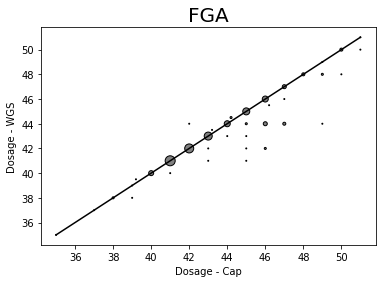

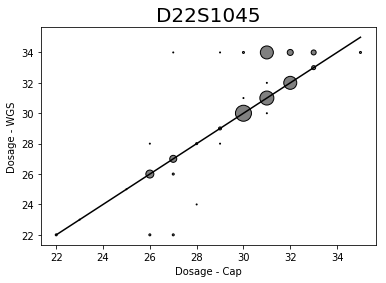

In [66]:
# Bubble plots
data["cap_d"] = data["Allele1 - Cap"]+data["Allele2 - Cap"]
data["wgs_d"] = data["Allele1 - WGS"]+data["Allele2 - WGS"]

locus_r2 = []
for l in perlocus["Marker"]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    d1 = data[(data["Marker"]==l) & (data["Sample ID"].apply(lambda x: x not in filt_samples))]
    d = d1.groupby(["cap_d","wgs_d"], as_index=False).agg({"Sample ID": len})
    ax.scatter(d["cap_d"], d["wgs_d"], s=d["Sample ID"]**2, color="gray", edgecolor="black")
    allvals = list(d["cap_d"])+list(d["wgs_d"])
    minval = min(allvals)
    maxval = max(allvals)
    ax.plot([minval, maxval], [minval, maxval], color="black")
    ax.set_xlabel("Dosage - Cap")
    ax.set_ylabel("Dosage - WGS")
    ax.set_title(l, size=20)
    fig.savefig("%s_bubble.pdf"%l)
    locus_r2.append(scipy.stats.pearsonr(d1["cap_d"], d1["wgs_d"])[0]**2)
perlocus_r2 = pd.DataFrame({"Marker": perlocus["Marker"], "r2": locus_r2})

In [67]:
filt_samples = ["GTEX-WHWD"]
########### Summarize concordance by locus ###############
perlocus = data[data["Sample ID"].apply(lambda x: x not in filt_samples)].groupby("Marker", as_index=False).agg({"gtconcordance": np.mean, \
                                                           "gtconcordance_int": np.mean, "gtconcordance_diff": np.mean, "Sample ID": len})
perlocus = pd.merge(perlocus, perlocus_r2, on=["Marker"])
perlocus = perlocus.sort_values("gtconcordance_diff", ascending=False)
perlocus.to_csv("GTEx_WGS_vs_capillary_perlocus.csv")
perlocus

,Marker,Sample ID,gtconcordance_diff,gtconcordance_int,gtconcordance,r2
9,D2S441,141,1.000000,1.000000,0.936170,0.997445
11,D5S818,136,1.000000,0.551471,0.551471,0.554999
16,TH01,141,1.000000,1.000000,0.531915,0.988880
13,D8S1179,129,1.000000,1.000000,1.000000,1.000000
12,D7S820,133,1.000000,1.000000,1.000000,1.000000
0,CSF1PO,140,0.992857,0.992857,0.992857,0.997328
3,D13S317,139,0.992806,0.992806,0.438849,0.985076
4,D16S539,135,0.992593,0.992593,0.992593,0.998169
14,DYS391,85,0.988235,0.988235,0.988235,0.990549
10,D3S1358,138,0.985507,0.985507,0.985507,0.996036


In [81]:
data[(data["Marker"]=="D22S1045") & (data["gtconcordance"]==0)]

,Sample ID,Marker,ID,Allele1 - Cap,Allele2 - Cap,Allele1 - WGS,Allele2 - WGS,Quality Score,Depth,Offset,gtconcordance,gtconcordance_int,gtconcordance_diff,cap_d,wgs_d
346,GTEX-OIZG,D22S1045,GTEX-OIZG:D22S1045,15.0,16.0,17.0,15.0,1,55.0,0,0,0,False,31.0,32.0
490,GTEX-OXRN,D22S1045,GTEX-OXRN:D22S1045,14.0,16.0,17.0,14.0,1,29.0,0,0,0,False,30.0,31.0
586,GTEX-P4PP,D22S1045,GTEX-P4PP:D22S1045,17.0,18.0,17.0,17.0,1,46.0,0,0,0,False,35.0,34.0
1042,GTEX-Q2AH,D22S1045,GTEX-Q2AH:D22S1045,10.0,17.0,17.0,17.0,1,28.0,0,0,0,False,27.0,34.0
1162,GTEX-QLQW,D22S1045,GTEX-QLQW:D22S1045,12.0,16.0,12.0,12.0,0.97,12.0,0,0,0,False,28.0,24.0
1186,GTEX-QMRM,D22S1045,GTEX-QMRM:D22S1045,15.0,16.0,17.0,17.0,1,9.0,0,0,0,False,31.0,34.0
1210,GTEX-QV31,D22S1045,GTEX-QV31:D22S1045,14.0,15.0,14.0,14.0,0.97,17.0,0,0,0,False,29.0,28.0
1234,GTEX-QV44,D22S1045,GTEX-QV44:D22S1045,15.0,16.0,17.0,17.0,1,15.0,0,0,0,False,31.0,34.0
1330,GTEX-R55E,D22S1045,GTEX-R55E:D22S1045,16.0,16.0,17.0,17.0,1,14.0,0,0,0,True,32.0,34.0
1354,GTEX-R55G,D22S1045,GTEX-R55G:D22S1045,16.0,16.0,17.0,17.0,1,13.0,0,0,0,True,32.0,34.0
